# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [122]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import typing
import math

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [123]:
def calc_probabilities(labels: np.ndarray) -> np.ndarray:
    n_labels = labels.shape[0]
    occur = dict()
    for label in labels:
        if label in occur:
            occur[label] += 1
        else:
            occur[label] = 1
    return np.array([occ / n_labels for occ in occur.values()])


def gini(labels: np.ndarray):
    return sum(p * (1 - p) for p in calc_probabilities(labels))


def entropy(labels: np.ndarray):
    return -sum(p * math.log(p) for p in calc_probabilities(labels))


def gain(left_y: np.ndarray, right_y: np.ndarray, criterion):
    left_size = left_y.shape[0]
    right_size = right_y.shape[0]
    return (left_size + right_size) * criterion(np.concatenate((left_y, right_y))) - \
           (left_size * criterion(left_y)) - \
           (right_size * criterion(right_y))

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__

Переделаем интерфейс у `DecisionTreeLeaf`, а именно добавим еще для каждого класса вероятность

In [146]:
class DecisionTreeLeaf:
    def __init__(self, ys: np.ndarray):
        occur = dict()
        ys = ys.reshape(ys.size)
        if ys.size > 0:
            for y in ys:
                if y in occur:
                    occur[y] += 1
                else:
                    occur[y] = 1
        for k in occur.keys():
            occur[k] /= ys.shape[0]
        self.probabilities = occur
        self.y = max(self.probabilities.keys(), key=lambda label: self.probabilities[label])


class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

### Задание 3 (3 балла)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [147]:
class DecisionTreeClassifier:

    def __init__(self, criterion: str = "gini", max_depth=None, min_samples_leaf: int = 1):
        self.root = None
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.criterion = gini if criterion == "gini" else entropy

    def build_tree(self, xs: np.ndarray, ys: np.ndarray, depth: int = 0):
        if np.sort(np.unique(ys)).size == 1 or depth == self.max_depth:
            return DecisionTreeLeaf(ys)

        best_dim = -1
        best_separator = -1
        best_ig = 0
        ids = [i for i in range(xs.shape[0])]

        for dim in range(xs.shape[1]):
            ids.sort(key=lambda i: xs[i][dim])
            for j in range(xs.shape[0]):
                if j > 0 and xs[ids[j]][dim] == xs[ids[j - 1]][dim] or min(j + 1, xs.shape[0] - j - 1) < self.min_samples_leaf:
                    continue
                left_y = np.array([ys[ids[q]] for q in range(j + 1)])
                right_y = np.array([ys[ids[q]] for q in range(j + 1, xs.shape[0])])
                ig = gain(left_y, right_y, self.criterion)

                if best_dim == -1 or ig > best_ig:
                    best_ig = ig
                    best_dim = dim
                    best_separator = j

        if best_dim == -1:
            return DecisionTreeLeaf(ys)

        ids.sort(key=lambda i: xs[i][best_dim])

        left_xs = np.array([xs[ids[q]] for q in range(0, best_separator + 1)])
        left_ys = np.array([ys[ids[q]] for q in range(0, best_separator + 1)])

        right_xs = np.array([xs[ids[q]] for q in range(best_separator + 1, xs.shape[0])])
        right_ys = np.array([ys[ids[q]] for q in range(best_separator + 1, xs.shape[0])])

        left_son = self.build_tree(left_xs, left_ys, depth + 1)
        right_son = self.build_tree(right_xs, right_ys, depth + 1)

        return DecisionTreeNode(best_dim, xs[best_separator + 1][best_dim], left_son, right_son)

    def fit(self, xs: np.ndarray, ys: np.ndarray):
        ys = ys.reshape(ys.size)
        self.root = self.build_tree(xs, ys)

    def get_probabilities(self, x: np.ndarray, node) -> dict:
        if isinstance(node, DecisionTreeLeaf):
            return node.probabilities
        if x[node.split_dim] < node.split_value:
            return self.get_probabilities(x, node.left)
        else:
            return self.get_probabilities(x, node.right)

    def predict_probabilities(self, xs: np.ndarray) -> typing.List[dict]:
        return [self.get_probabilities(x, self.root) for x in xs]

    def predict(self, xs: np.ndarray) -> np.ndarray:
        probabilities = self.predict_probabilities(xs)
        return np.array([max(p.keys(), key=lambda k: p[k]) for p in probabilities])

    def explain(self, x: np.ndarray, node):
        if isinstance(node, DecisionTreeLeaf):
            return node.y, ''
        if x[node.split_dim] < node.split_value:
            y, s = self.explain(x, node.left)
            s += f'\nx[{node.split_dim}] < {node.split_value}'
            return y, s
        else:
            y, s = self.explain(x, node.right)
            s += f'\nx[{node.split_dim}] >= {node.split_dim}'
            return y, s

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [148]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [149]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Наконец, протестируем дерево решений на синтетических наборах данных.

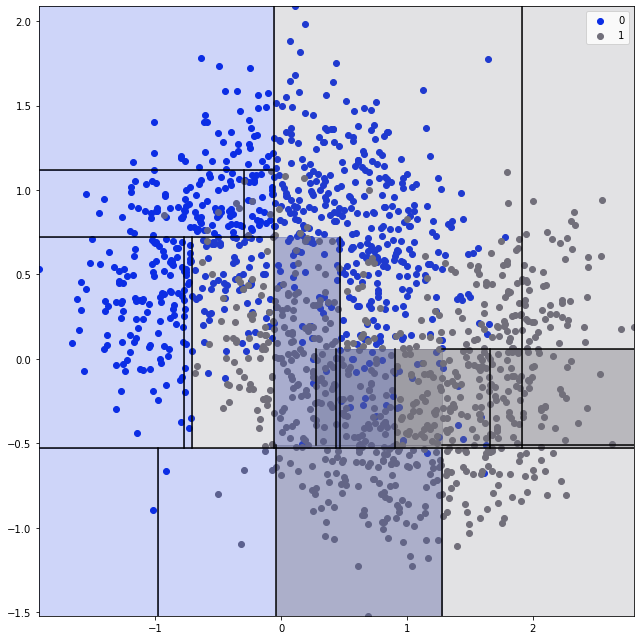

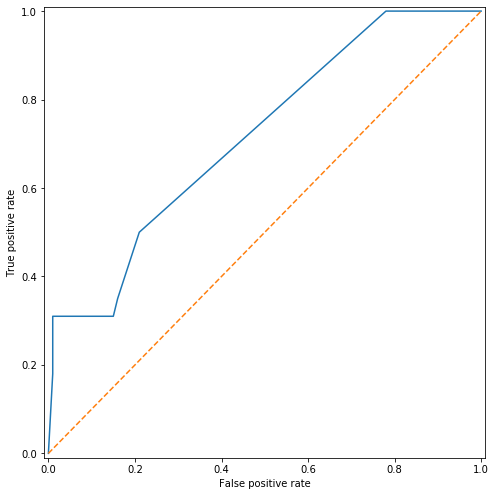

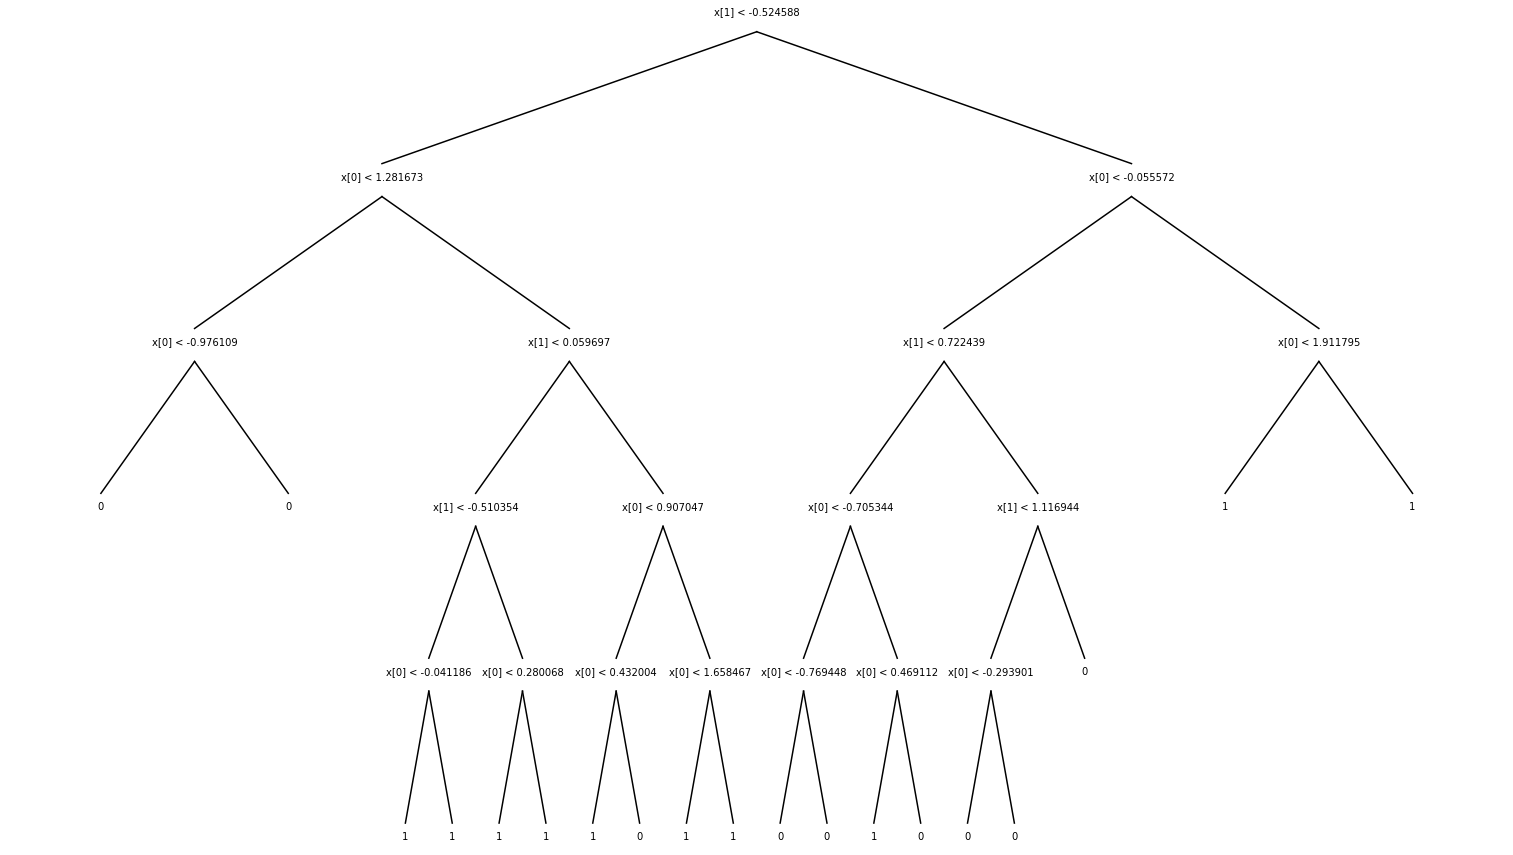

In [150]:
noise = 0.35
X, y = make_moons(1500, noise=noise)
X_test, y_test = make_moons(200, noise=noise)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
plot_roc_curve(y_test, tree.predict_probabilities(X_test))
draw_tree(tree)

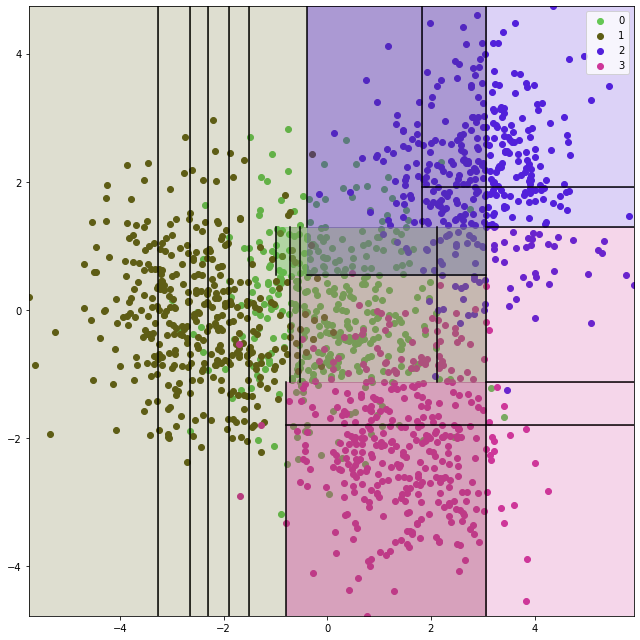

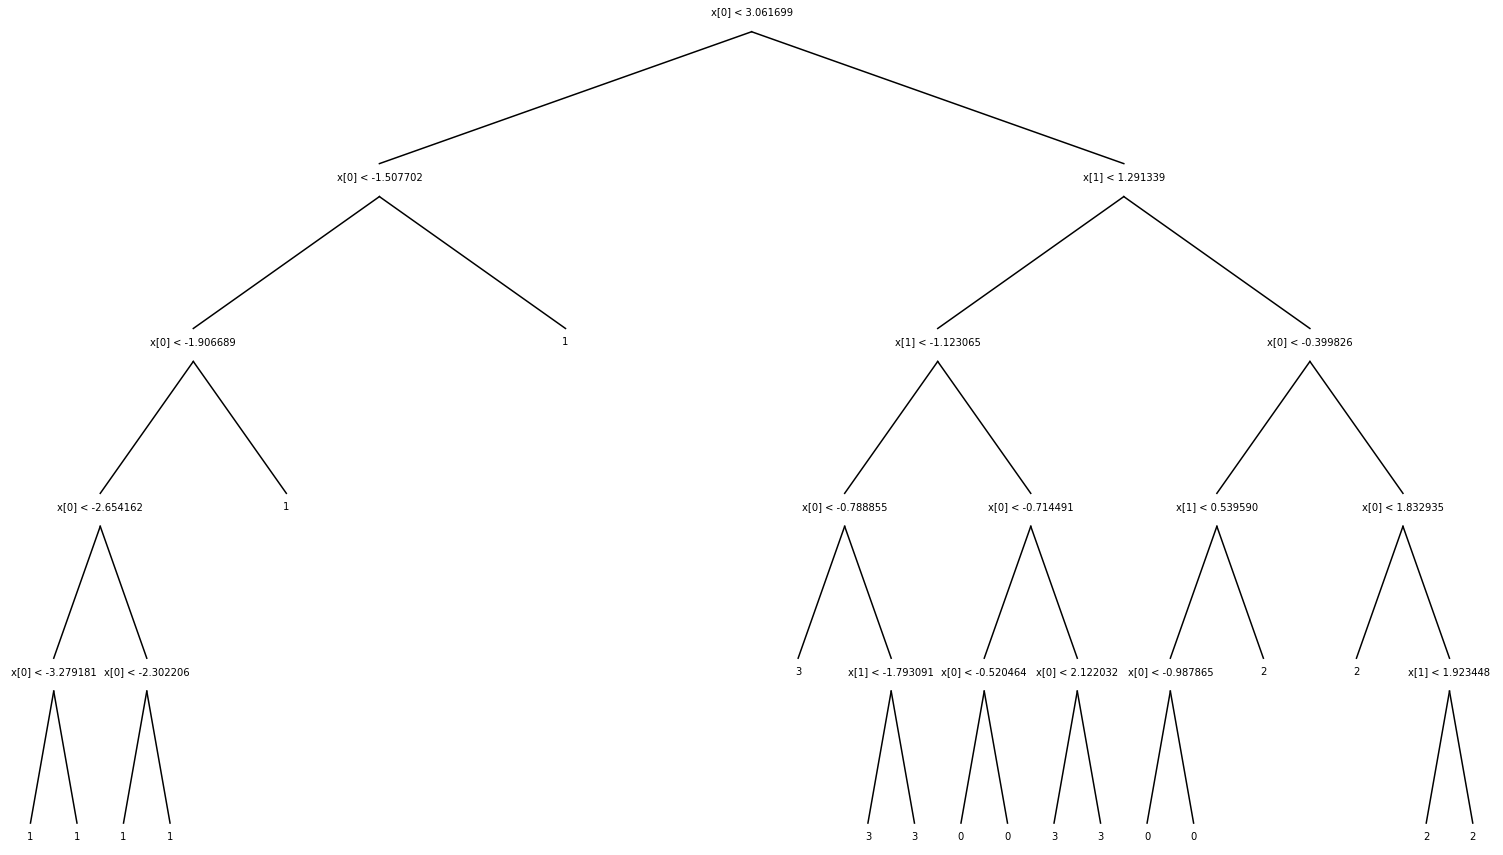

In [151]:
X, y = make_blobs(1500, 2, centers=[[0, 0], [-2.5, 0], [3, 2], [1.5, -2.0]])
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
draw_tree(tree)

### Задание 4 (3 балла)
У малоизвестной MMORPG Smash Art Online удалилась часть базы данных, а бэкапа не оказалось. Уволив сисадмина, тимлид начал думать, как проще и быстрее разрешить ситуацию. Оказалось, что в основном пострадала информация о классах персонажей, но зато часть внутриигровой статистики осталась нетронутой. Было решено не перезапускать игровой мир, а попробовать восстановить утерянные данные.

Посчитав, что ручное восстановление классов персонажей было бы очень долгим и вызвало бы недовольство игроков, тимлид решил пригласить специалиста по машинному обучению, который смог бы восстановить большую часть данных автоматически. 

Ваша задача - построить дерево решений, которое как можно более точно восстанавливает класс персонажа. В этом вам поможет статистика персонажей, а так же сохранившаяся часть классов персонажей. Чтобы дерево было достаточно интерпретируемым, его высота должна быть не больше `6`.


#### Оценка задания
Баллы за это задание выставляются в зависимости от точности полученного классификатора на закрытой части выборки:
1. __Точность > 50%__ - 1 балл - классификатор значительно облегчил команде игры задачу по восстановлению классов игроков. Тимлид доволен и, вероятно, захочет продолжить сотрудничество в дальнейшем
2. __Точность > 85%__ - 3 балла - классификатор сделал большую часть работы. Довольный тимлид задумчиво чешет подбородок, а затем предлагает сотрудничество на постоянной основе

__Важно: метки классов - названия, а не числа. Пусть так и остается.__

In [152]:
def read_dataset(path):
    dataframe = pandas.read_csv(path, header=1)
    dataset = dataframe.values.tolist()
    random.shuffle(dataset)
    y = [row[0] for row in dataset]
    X = [row[1:] for row in dataset]
    return np.array(X), np.array(y)

accuracy =  0.6166666666666667


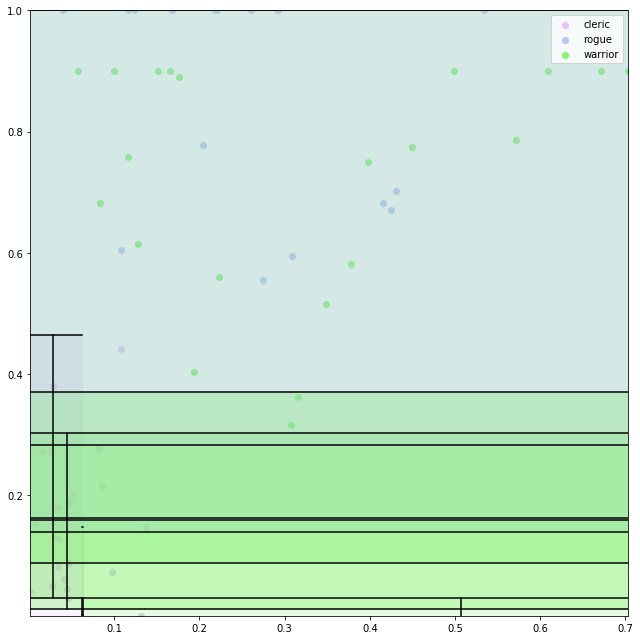

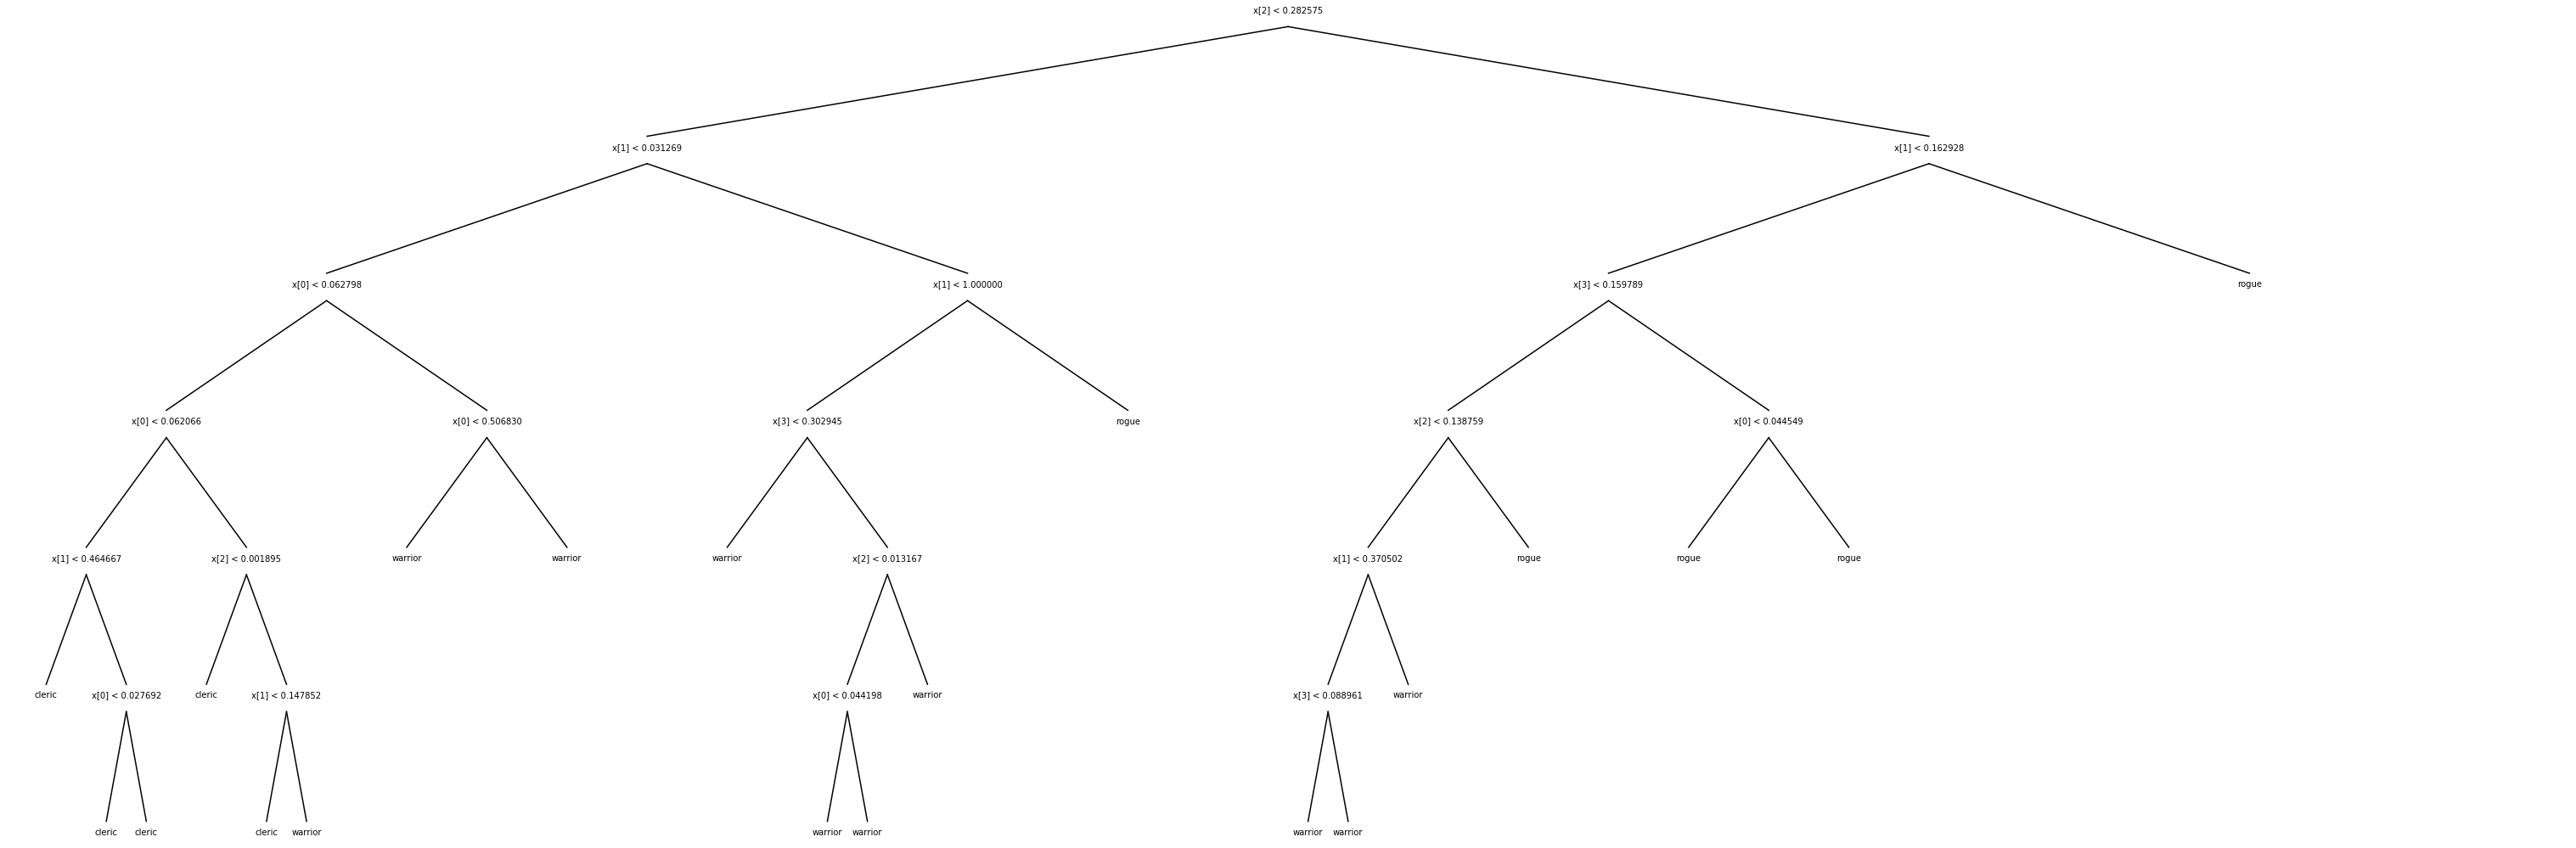

In [174]:
X, y = read_dataset("train.csv")
_min = X.min(axis=0)
_max = X.max(axis=0)
X = (X - _min) / (_max - _min)

ratio = 0.9
sep = int(ratio * X.shape[0])

X_train = X[:sep]
y_train = y[:sep]

X_test = X[sep:]
y_test = y[sep:]

dtc = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, criterion="entropy")
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)
print('accuracy = ', sum(1 for i in range(y_pred.size) if y_pred[i] == y_test[i]) / y_pred.size)

plot_2d(dtc, X_test, y_test)
draw_tree(dtc)

### Задание 5 (1 балл)
От игроков начали поступать жалобы на то, что класс их персонажа внезапно сменился. В таких случаях модераторы смотрят на данные персонажа и пытаются восстановить его класс сами. Для того, чтобы им было проще это сделать, нужно научиться для каждого персонажа объяснять, почему дерево решений присвоило персонажу именно такой класс.

Реализуйте функцию `predict_explain(dtc, X)`. Для каждого элемента элемента набора данных `X` она должна вернуть пару из предсказанного класса и человекочетаемой строковой записи условий, благодаря которым был предсказан класс. 

In [132]:
def predict_explain(dtc: DecisionTreeClassifier, xs: np.ndarray) -> list:
    return [dtc.explain(x, dtc.root) for x in xs]

In [133]:
X, y = read_dataset("train.csv")
for pred_y, expl in predict_explain(dtc, X[:20]):
    print("Class:", pred_y)
    print("Explanation:", expl)
    print()

Class: warrior
Explanation: 
x[3] >= 3
x[0] >= 0
x[1] >= 1
x[2] >= 2
x[2] >= 2
x[1] < 1.0

Class: warrior
Explanation: 
x[3] >= 3
x[0] >= 0
x[1] >= 1
x[2] >= 2
x[2] >= 2
x[1] < 1.0

Class: rogue
Explanation: 
x[0] < 0.4924214412628853
x[1] >= 1
x[2] >= 2
x[2] >= 2
x[1] < 1.0

Class: warrior
Explanation: 
x[3] >= 3
x[0] >= 0
x[1] >= 1
x[2] >= 2
x[2] >= 2
x[1] < 1.0

Class: warrior
Explanation: 
x[3] >= 3
x[0] >= 0
x[1] >= 1
x[2] >= 2
x[2] >= 2
x[1] < 1.0

Class: warrior
Explanation: 
x[3] >= 3
x[0] >= 0
x[1] >= 1
x[2] >= 2
x[2] >= 2
x[1] < 1.0

Class: rogue
Explanation: 
x[1] >= 1
x[1] >= 1

Class: warrior
Explanation: 
x[3] >= 3
x[0] >= 0
x[1] >= 1
x[2] >= 2
x[2] >= 2
x[1] < 1.0

Class: warrior
Explanation: 
x[3] >= 3
x[0] >= 0
x[1] >= 1
x[2] >= 2
x[2] >= 2
x[1] < 1.0

Class: warrior
Explanation: 
x[3] >= 3
x[0] >= 0
x[1] >= 1
x[2] >= 2
x[2] >= 2
x[1] < 1.0

Class: rogue
Explanation: 
x[1] < 0.09854243787611043
x[2] >= 2
x[2] >= 2
x[1] < 1.0

Class: rogue
Explanation: 
x[1] >= 1
x[1] >